In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf                                        
import tensorflow.math as tfmath
import tensorflow.keras as keras
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk
from sklearn.preprocessing import StandardScaler

2025-01-25 05:29:23.116798: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 05:29:24.603057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, Concatenate, Dense, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
import qkeras
from qkeras import QActivation, QDense
from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2
from qkeras import QDenseBatchnorm

In [3]:
print(tf.__version__)
print(qkeras.__version__)

2.13.1
0.9.0


In [4]:
# Import math Library
import math
phi_res = 128/(2*math.pi)
print(phi_res)

20.371832715762604


In [5]:
def load_and_preprocess_data(file_path):
    with h5py.File(file_path, 'r') as hf:
        # Define object counts
        nmuon, nSRjet, netau = 4, 6, 4
        def fix_phi_range(phi_data):
            # Map values to [0,2pi] range
            phi_fixed = phi_data % (2*math.pi)
            # Scale to [0,128) range and round to nearest integer
            phi_scaled = np.round(phi_fixed * 128/(2*math.pi))
            
            # Take modulo 128 to handle edge cases
            phi_binned = phi_scaled % 128
            return phi_binned
        # Load and reshape datasets with scaling
        def load_and_scale(dataset, n_objects, scale_factor=10, eta_factor=40):
            data = hf[dataset][:, 0:n_objects, :]
            data[:, :, 0] *= scale_factor  # Scale the pT value
            data[:, :, 1] *= eta_factor  # Scale the angle value
            data[:, :, 2] = fix_phi_range(data[:, :, 2])
            return data.reshape(-1, 3 * n_objects)

        L1_jFexSR_jets = load_and_scale('L1_jFexSR_jets', nSRjet)
        L1_muons = load_and_scale('L1_muons', nmuon, scale_factor=10000)
        L1_eFex_taus = load_and_scale('L1_eFex_taus', netau)

        # Load and process MET
        L1_MET = hf['L1_MET'][:]
        L1_MET[:, 0] *= 40
        L1_MET[:, 2] = fix_phi_range(L1_MET[:, 2])
        
        L1_MET_fixed = np.zeros((L1_MET.shape[0], 2))
        L1_MET_fixed[:, 0] = L1_MET[:, 0]
        L1_MET_fixed[:, 1] = L1_MET[:, 2]
        L1_MET = L1_MET_fixed

        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        
        # Combine arrays into Topo 2A
        Topo_2A = np.concatenate([L1_jFexSR_jets, L1_eFex_taus, L1_muons, L1_MET], axis=1)
        
        # Load mu information and create mask after Topo_2A creation
        mu_data = hf['mu'][:]
        valid_events_mask = mu_data != 0
        
        # Apply filter to all relevant arrays
        Topo_2A = Topo_2A[valid_events_mask]
        pass_L1_unprescaled = pass_L1_unprescaled[valid_events_mask]
        mu_data = mu_data[valid_events_mask]
        
        print("Shape of Topo_2A after mu filtering:", Topo_2A.shape)
        print(f"Number of events removed due to mu=0: {np.sum(valid_events_mask == 0)}")
        print(f"Percentage of events kept: {(np.sum(valid_events_mask)/len(valid_events_mask))*100:.2f}%")

        return Topo_2A, pass_L1_unprescaled

In [6]:
def load_and_preprocess_multiple_files(file_paths):
    # Initialize lists to store data from each file
    all_Topo_2A = []
    all_pass_L1 = []
    
    # Load data from each file
    for file_path in file_paths:
        Topo_2A, pass_L1_unprescaled = load_and_preprocess_data(file_path)
        
        all_Topo_2A.append(Topo_2A)
        all_pass_L1.append(pass_L1_unprescaled)
    
    # Concatenate all files' data
    final_Topo_2A = np.concatenate(all_Topo_2A, axis=0)
    final_pass_L1 = np.concatenate(all_pass_L1, axis=0)
    
    # Get total number of samples
    n_samples = final_Topo_2A.shape[0]
    
    # Set random seed and create shuffle indices
    np.random.seed(42)
    shuffle_idx = np.random.permutation(n_samples)
    
    # Shuffle all arrays using the same indices
    final_Topo_2A = final_Topo_2A[shuffle_idx]
    final_pass_L1 = final_pass_L1[shuffle_idx]
    Topo_2A_labels = ['L1_jFexSR_jets', 'L1_eFex_taus', 'L1_muons', 'L1_MET']

    print(f"total of {n_samples} event processed")
    return final_Topo_2A, Topo_2A_labels, final_pass_L1


In [7]:
file_paths = [
    '/eos/home-m/mmcohen/ntuples/EB_h5_10-06-2024/EB_473255_0_10-05-2024.h5',
    '/eos/home-m/mmcohen/ntuples/EB_h5_10-06-2024/EB_475321_0_10-05-2024.h5',
    '/eos/home-m/mmcohen/ntuples/EB_h5_10-06-2024/EB_482596_0_10-05-2024.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_474448_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_474462_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_474562_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_474657_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_474679_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_474926_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_474991_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_475008_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_475052_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_475066_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_475168_1-16-2025.h5',
    '/eos/home-m/mmcohen/ntuples/data24_ZeroBias/ZeroBias_475192_1-16-2025.h5',
]

In [8]:
Topo_2A, Topo_2A_labels, pass_L1 = load_and_preprocess_multiple_files(file_paths)

Shape of Topo_2A after mu filtering: (722940, 44)
Number of events removed due to mu=0: 423172
Percentage of events kept: 63.08%
Shape of Topo_2A after mu filtering: (913037, 44)
Number of events removed due to mu=0: 206620
Percentage of events kept: 81.55%
Shape of Topo_2A after mu filtering: (900995, 44)
Number of events removed due to mu=0: 147341
Percentage of events kept: 85.95%
Shape of Topo_2A after mu filtering: (150853, 44)
Number of events removed due to mu=0: 0
Percentage of events kept: 100.00%
Shape of Topo_2A after mu filtering: (259271, 44)
Number of events removed due to mu=0: 0
Percentage of events kept: 100.00%
Shape of Topo_2A after mu filtering: (437635, 44)
Number of events removed due to mu=0: 0
Percentage of events kept: 100.00%
Shape of Topo_2A after mu filtering: (390115, 44)
Number of events removed due to mu=0: 0
Percentage of events kept: 100.00%
Shape of Topo_2A after mu filtering: (429306, 44)
Number of events removed due to mu=0: 0
Percentage of events ke

In [ ]:
print(Topo_2A.shape[0])

6342309


In [9]:
Topo_2A_test=Topo_2A[0:3000000,:]
def replace_nan_with_median(data):
    # Ensure the input is a numpy array
    data = np.asarray(data)
    
    # Number of variables (columns)
    num_variables = data.shape[1]
    
    # Iterate over each variable
    for i in range(num_variables):
        # Compute the median of the i-th variable, ignoring NaNs
        median = np.nanmedian(data[:, i])
        
        # Find NaN indices in the column
        nan_indices = np.where(np.isnan(data[:, i]))[0]
        
        for index in nan_indices:
            print(f"NaN found at index {index}, variable {i}")
        
        # Replace NaNs with the median of the respective variable
        data[nan_indices, i] = 0 #median
    
    return data
Topo_2A_test = replace_nan_with_median(Topo_2A_test)

In [10]:
L1_pass_test = pass_L1[0:3000000]
Topo_2A_test_L1failed = Topo_2A_test[L1_pass_test==0]
# Topo_2A_test_L1passed = Topo_2A_test[L1_pass_test==1]

In [11]:

scaler = StandardScaler()
scaler.fit(Topo_2A_test_L1failed)


StandardScaler()

In [12]:
mean = scaler.mean_
std = scaler.scale_
print("Mean (bias):", mean)
print("Standard deviation (scale):", std)
def closest_power_of_2(arr):
    return [int(round(math.log2(max(abs(x), 1e-10)))) for x in arr]
result = closest_power_of_2(std)
print(result)

Mean (bias): [ 7.33277346e+01 -2.18072576e+00  1.61397821e+01  2.69180954e+01
 -8.74811250e-01  6.78290944e+00  8.65999059e+00 -4.70687212e-01
  2.68290556e+00  3.17984844e+00 -2.62338148e-01  1.08523404e+00
  1.34963139e+00 -1.43799270e-01  4.78879294e-01  6.55273340e-01
 -9.01666901e-02  2.35549565e-01  3.23112045e+01  3.58874465e-01
  1.96532220e+01  8.84126006e+00  9.65750688e-02  6.55819978e+00
  2.35128846e+00  3.07896935e-02  2.17491245e+00  6.71813644e-01
  1.37798439e-02  6.84581061e-01  5.57142489e+00  3.75284025e-01
  6.35045511e+00  5.72468439e-01  4.99871706e-02  8.04503112e-01
  6.00209233e-02  4.93390652e-03  9.84301450e-02  3.02889112e-03
  5.81686208e-05  4.87827744e-03  4.04633702e+02  6.72443658e+01]
Standard deviation (scale): [157.75513271  42.53572991  33.23869891  90.73197139  27.1618008
  23.05176116  43.1784692   18.25862939  14.85457141  24.53772379
  12.457317     9.53297681  15.67215563   8.74650612   6.34705078
  10.81545893   6.48310534   4.45872441  67.30

In [13]:
def apply_power_of_2_scaling(X, result):
    
    # Apply the scaling using 2 raised to the power of the result
    X_scaled = X / (2.0 ** np.array(result))
    
    return X_scaled
# def pt_scaling(X):
#     pt_scale = [5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0]
#     X_scaled = X * (2.0 ** np.array(pt_scale))
    
#     return X_scaled
Topo_2A_test_L1failed = apply_power_of_2_scaling(Topo_2A_test_L1failed, result)
# Topo_2A_test_L1failed = pt_scaling(Topo_2A_test_L1failed)

In [ ]:
print("Shape of Topo_2A_test_L1failed:", Topo_2A_test_L1failed.shape)

Shape of Topo_2A_test_L1failed: (2495963, 44)


In [14]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = QDenseBatchnorm(h_dim_1,
             kernel_quantizer=quantized_bits(10,5,0,alpha=1),
             bias_quantizer=quantized_bits(10,5,0,alpha=1),
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x = QActivation(quantized_relu(15, negative_slope=1/1024))(x)
    x = QDenseBatchnorm(h_dim_2,
             kernel_quantizer=quantized_bits(10,5,0,alpha=1),
             bias_quantizer=quantized_bits(10,5,0,alpha=1),
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    x = QActivation(quantized_relu(15, negative_slope=1/1024))(x)
    z_mean=QDense(latent_dim, name='z_mean',
                  kernel_quantizer=quantized_bits(10,5,0,alpha=1),
                  bias_quantizer=quantized_bits(10,5,0,alpha=1),
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x = BatchNormalization(name="BN_decode1")(x)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    x = BatchNormalization(name="BN_decode2")(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def Qmake_discriminator(input_dim, h_dim_1, h_dim_2):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = Dense(h_dim_1,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x = Dense(h_dim_2,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    # x = Dense(h_dim_3,
    #           activation='relu',
    #           kernel_initializer=keras.initializers.HeNormal(seed=None),
    #           bias_initializer=keras.initializers.Zeros(),
    #           kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    x = Dense(1,
              activation='sigmoid',  # Output probability
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    discriminator = keras.Model(inputs, x, name='discriminator')
    return discriminator

def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
    jet_scale = 32
    tau_scale = 32
    muon_sacle = 32
    met_scale = 32

    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: jet_scale,
        3: jet_scale,
        6: jet_scale,
        9: jet_scale,
        12: jet_scale,
        15: jet_scale,
        18: tau_scale,
        21: tau_scale,
        24: tau_scale,
        27: tau_scale,
        30: muon_sacle,
        33: muon_sacle,
        36: muon_sacle,
        39: muon_sacle,
        42: met_scale
    }
    
    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)
    
    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor
    
#     # Hardcoded lists for eta and phi indices
#     eta_indices = [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40]
#     phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 43]

#     batch_size = tf.shape(scaled_reconstruction)[0]
    
#     # Apply constraints to eta
#     for i in eta_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
#     # Apply constraints to phi
#     for i in phi_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3.14159265258979*(10/8) * tf.tanh(scaled_reconstruction[:, i] / (3.14159265258979*(10/8)))
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)
    
    # Take the mean across all dimensions
    return tf.reduce_mean(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, discriminator, steps_per_epoch, cycle_length=20, min_beta=0, max_beta=1, min_gamma=0, max_gamma=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder        
        self.discriminator = discriminator
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gamma_tracker = keras.metrics.Mean(name="gamma")
        
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)
        self.min_gamma = tf.cast(min_gamma, tf.float32)
        self.max_gamma = tf.cast(max_gamma, tf.float32)
        self.gamma = tf.Variable(min_gamma, dtype=tf.float32)

    def compile(self, optimizer, **kwargs):
        super(VAE_Model, self).compile(**kwargs)
        # Set the optimizer for the entire model (encoder + decoder + discriminator)
        self.optimizer = optimizer

        # Collect trainable variables from encoder, decoder, and discriminator
        trainable_variables = (
            self.encoder.trainable_weights + 
            self.decoder.trainable_weights + 
            self.discriminator.trainable_weights
        )
        # Build the optimizer with the full variable list
        self.optimizer.build(trainable_variables)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.discriminator_loss_tracker,
            self.beta_tracker,
        ]
    def cyclical_annealing_beta(self, epoch):
        # Get position within current cycle (0 to cycle_length)
        cycle_position = tf.math.mod(epoch, self.cycle_length)
        
        # For first half of cycle, increase linearly
        # For second half, stay at max
        half_cycle = self.cycle_length / 2
        scaled_x = tf.where(cycle_position <= half_cycle,
                        cycle_position / half_cycle,  # Linear increase in first half
                        1.0)                         # Stay at max for second half
        
        return self.min_beta + (self.max_beta - self.min_beta) * scaled_x
    def get_gamma_schedule(self, epoch):
        # Convert to float32 for TF operations
        epoch = tf.cast(epoch, tf.float32)
        
        # Calculate annealing progress
        anneal_progress = (epoch - 0.0) / 100.0
        gamma_anneal = self.min_gamma + (self.max_gamma - self.min_gamma) * anneal_progress        
        return gamma_anneal
    
    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        epoch = epoch / 2
        # Update beta gamma
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        self.gamma.assign(self.get_gamma_schedule(epoch))

        # ---------------------------
        # Train the Discriminator
        # ---------------------------
        with tf.GradientTape() as tape_disc:
            # Generate reconstructed data
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            # Get discriminator predictions
            real_output = self.discriminator(data)
            fake_output = self.discriminator(reconstruction * mask)
            
            # Labels for real and fake data
            real_labels = tf.ones_like(real_output)# * 0.9
            fake_labels = tf.zeros_like(fake_output)# + 0.1
            
            # tf.print("Real data shape:", tf.shape(real_output))
            # tf.print("Fake data shape:", tf.shape(fake_output))
            
            # # Print the values using tf.print
            # tf.print("Real data:", real_output[:5])
            # tf.print("\nFake data:", fake_output[:5])

            # Discriminator loss
            d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
            d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
            d_loss = d_loss_real + d_loss_fake
            d_loss = tf.reduce_mean(d_loss)
        
        grads_disc = tape_disc.gradient(d_loss, self.discriminator.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_weights))

        # ---------------------------
        # Train the VAE (Generator)
        # ---------------------------
        with tf.GradientTape() as tape:
            data_noisy = data + tf.random.normal(tf.shape(data), 
                                               mean=0, 
                                               stddev=0)
            # Keep the mask logic
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            data_noisy = data_noisy * mask  # Apply mask to noisy data
            
            z_mean, z_log_var, z = self.encoder(data_noisy)
            reconstruction = self.decoder(z)
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)

            # Generator (VAE) wants to fool the discriminator
            fake_output = self.discriminator(reconstruction * mask)
            valid_labels = tf.ones_like(fake_output)# * 0.9
            g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
            g_loss_adv = tf.reduce_mean(g_loss_adv)

            total_loss = reconstruction_loss + kl_loss * self.beta + g_loss_adv * self.gamma
            
        grads_vae = tape.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_vae, self.encoder.trainable_weights + self.decoder.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.discriminator_loss_tracker.update_state(g_loss_adv)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "disc_loss": self.discriminator_loss_tracker.result(),
            "beta": self.beta,
            "gamma": self.gamma,
            "raw_loss": self.reconstruction_loss_tracker.result() + self.kl_loss_tracker.result(),
            "w_kl_loss": self.kl_loss_tracker.result() * self.beta,
            "w_disc_loss": self.discriminator_loss_tracker.result() * self.gamma,
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        # Discriminator loss (only for monitoring)
        # pass both data and reconstruction through D to get generator adversarial loss
        real_output = self.discriminator(data)
        fake_output = self.discriminator(mask*reconstruction)
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)
        d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
        d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake
        d_loss = tf.reduce_mean(d_loss)
        
        # Generator adversarial loss
        valid_labels = tf.ones_like(fake_output)
        g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
        g_loss_adv = tf.reduce_mean(g_loss_adv)
        total_loss = reconstruction_loss + kl_loss * self.beta + g_loss_adv * self.gamma
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "raw_loss": reconstruction_loss + kl_loss,
            "disc_loss": g_loss_adv,
            "w_kl_loss": kl_loss * self.beta,
            "w_disc_loss": g_loss_adv * self.gamma
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

In [15]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [16]:
NUM_EPOCHS = 120
BATCH_SIZE = 1024
STOP_PATIENCE = 40
LR_PATIENCE = 20

In [ ]:
print(Topo_2A_test_L1failed.shape[0] // BATCH_SIZE)

2437


In [17]:
#TOPO 2A Trainer

T2A_enc = Qmake_encoder_set_weights(Topo_2A.shape[1],32,16,3)
T2A_dec = Qmake_decoder_set_weights(Topo_2A.shape[1],32,16,3)
T2A_discriminator = Qmake_discriminator(Topo_2A.shape[1],8,2)

steps_per_epoch = Topo_2A_test_L1failed.shape[0] // BATCH_SIZE
T2A = VAE_Model(T2A_enc, T2A_dec, T2A_discriminator, steps_per_epoch=steps_per_epoch, cycle_length=20, min_beta=0, max_beta=1, min_gamma=1, max_gamma=50)
# T2A.set_beta(beta)
opt = keras.optimizers.Adam(learning_rate=0.001)
T2A.compile(optimizer=opt) #,weighted_metrics=[weighted_mse]
# T2A.build(input_shape=(997315, 110))
T2A_enc.summary()
T2A_dec.summary()
T2A_discriminator.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 44)]                 0         []                            
                                                                                                  
 q_dense_batchnorm (QDenseB  (None, 32)                   1569      ['input_1[0][0]']             
 atchnorm)                                                                                        
                                                                                                  
 q_activation (QActivation)  (None, 32)                   0         ['q_dense_batchnorm[0][0]']   
                                                                                                  
 q_dense_batchnorm_1 (QDens  (None, 16)                   593       ['q_activation[0][0]']  

In [ ]:
print(Topo_2A_test_L1failed.shape)

(2495963, 44)


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=STOP_PATIENCE, restore_best_weights=True, start_from_epoch=50)
reduce_lr = ReduceLROnPlateau(monitor='val_reco_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)
checkpoint_total = ModelCheckpoint(
    filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/versionFDL-GAN_ALT/best_total_loss/',
    monitor='val_raw_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

checkpoint_reco = ModelCheckpoint(
    filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/versionFDL-GAN_ALT/best_reco_loss/',
    monitor='val_reco_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

checkpoint_kl = ModelCheckpoint(
    filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/versionFDL-GAN_ALT/best_kl_loss/',
    monitor='val_kl_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)
callbacks = [early_stopping, reduce_lr, checkpoint_total, checkpoint_reco, checkpoint_kl]

tf.keras.backend.clear_session()
history = T2A.fit(x=Topo_2A_test_L1failed, validation_split=0.1, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)#, sample_weight=Topo_t_weights
# T2A.save_weights(filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/versionFDL-GAN/', save_format='tf')

Epoch 1/120
2194/2194 [==============================] - 13s 5ms/step - loss: 120.0536 - reco_loss: 119.2163 - kl_loss: 2.1058 - disc_loss: 0.7111 - beta: 0.0900 - gamma: 1.2206 - raw_loss: 120.6963 - w_kl_loss: 0.0780 - w_disc_loss: 0.8701 - val_loss: 26.9902 - val_reco_loss: 25.5326 - val_kl_loss: 2.9481 - val_raw_loss: 28.4807 - val_disc_loss: 0.8274 - val_w_kl_loss: 0.2653 - val_w_disc_loss: 1.1923 - lr: 0.0010
Epoch 2/120
2194/2194 [==============================] - 10s 5ms/step - loss: 23.8287 - reco_loss: 22.3218 - kl_loss: 3.1053 - disc_loss: 0.7480 - beta: 0.1800 - gamma: 1.6617 - raw_loss: 25.3941 - w_kl_loss: 0.4160 - w_disc_loss: 1.2424 - val_loss: 21.0125 - val_reco_loss: 18.8952 - val_kl_loss: 3.0261 - val_raw_loss: 21.9213 - val_disc_loss: 0.8355 - val_w_kl_loss: 0.5447 - val_w_disc_loss: 1.5725 - lr: 0.0010
Epoch 3/120
2194/2194 [==============================] - 10s 5ms/step - loss: 23.4451 - reco_loss: 21.3511 - kl_loss: 3.0556 - disc_loss: 0.7391 - beta: 0.2700 - gam

In [ ]:
T2A.save_weights(filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/versionFDL-GAN/final/', save_format='tf')

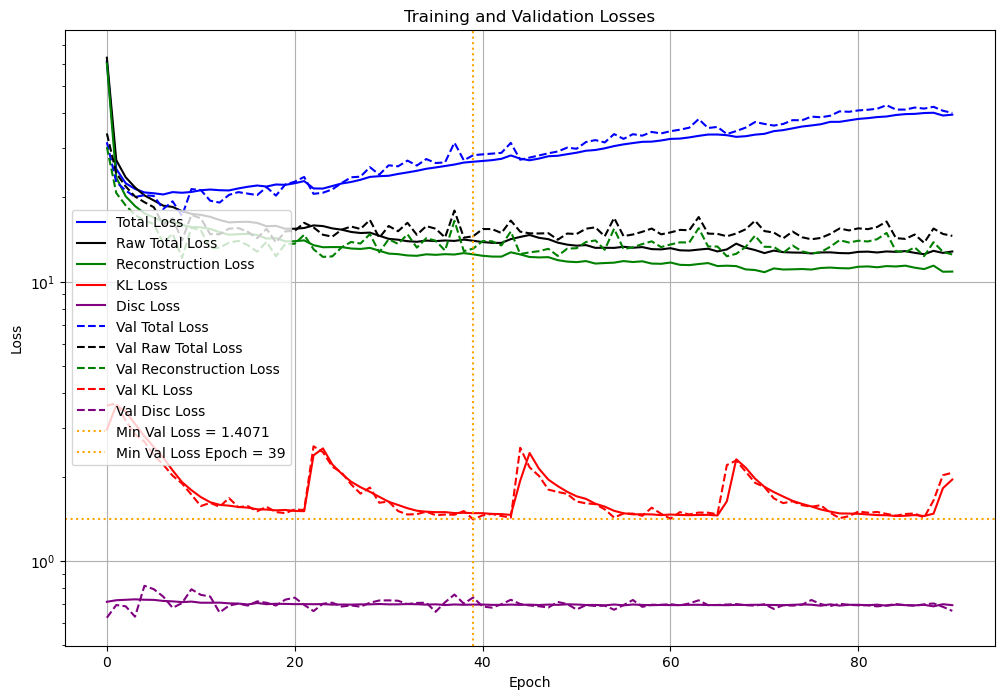

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']
raw_loss = history.history['raw_loss']
val_raw_loss = history.history['val_raw_loss']
w_kl_loss = history.history['w_kl_loss']
val_w_kl_loss = history.history['val_w_kl_loss']
disc_loss = history.history['disc_loss']
val_disc_loss = history.history['val_disc_loss']
min_val = np.min(val_kl_loss)
min_val_epoch = np.argmin(val_kl_loss)
# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(raw_loss, label='Raw Total Loss', color='black')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')
# plt.plot(w_kl_loss, label='weighted KL Loss', color='red')

plt.plot(disc_loss, label='Disc Loss', color='purple')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(np.add(val_reco_loss, val_kl_loss), label='Val Raw Total Loss', color='black', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')
# plt.plot(val_w_kl_loss, label='Val weighted KL Loss', color='red', linestyle='--')

plt.plot(val_disc_loss, label='Val Disc Loss', color='purple', linestyle='--')

# Add horizontal line at minimum validation raw loss
plt.axhline(y=min_val, color='orange', linestyle=':', label=f'Min Val Loss = {min_val:.4f}')
plt.axvline(x=min_val_epoch, color='orange', linestyle=':', label=f'Min Val Loss Epoch = {min_val_epoch}')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
# plt.ylim(1e-2,1)
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [18]:
for i in range(20, 30):
    T2A_enc = Qmake_encoder_set_weights(Topo_2A.shape[1],32,16,3)
    T2A_dec = Qmake_decoder_set_weights(Topo_2A.shape[1],32,16,3)
    T2A_discriminator = Qmake_discriminator(Topo_2A.shape[1],8,2)

    steps_per_epoch = Topo_2A_test_L1failed.shape[0] // BATCH_SIZE
    T2A = VAE_Model(T2A_enc, T2A_dec, T2A_discriminator, steps_per_epoch=steps_per_epoch, cycle_length=20, min_beta=0, max_beta=1, min_gamma=1, max_gamma=50)
    # T2A.set_beta(beta)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    T2A.compile(optimizer=opt)

    early_stopping = EarlyStopping(monitor="val_loss", patience=STOP_PATIENCE, restore_best_weights=True, start_from_epoch=50)
    reduce_lr = ReduceLROnPlateau(monitor='val_reco_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

    checkpoint_kl = ModelCheckpoint(
        filepath='/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_GANALT_{}/'.format(i),
        monitor='val_kl_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
    callbacks = [early_stopping, reduce_lr, checkpoint_kl]

    tf.keras.backend.clear_session()
    history = T2A.fit(x=Topo_2A_test_L1failed, validation_split=0.1, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)

Epoch 1/120
2194/2194 [==============================] - 20s 4ms/step - loss: 122.1305 - reco_loss: 121.2865 - kl_loss: 2.9399 - disc_loss: 0.6998 - beta: 0.0900 - gamma: 1.2206 - raw_loss: 123.2292 - w_kl_loss: 0.1085 - w_disc_loss: 0.8545 - val_loss: 31.1559 - val_reco_loss: 29.7633 - val_kl_loss: 3.8588 - val_raw_loss: 33.6221 - val_disc_loss: 0.7255 - val_w_kl_loss: 0.3472 - val_w_disc_loss: 1.0453 - lr: 0.0010
Epoch 2/120
2194/2194 [==============================] - 8s 4ms/step - loss: 24.4243 - reco_loss: 22.8792 - kl_loss: 3.8690 - disc_loss: 0.7128 - beta: 0.1800 - gamma: 1.6617 - raw_loss: 26.7871 - w_kl_loss: 0.5273 - w_disc_loss: 1.1844 - val_loss: 23.6577 - val_reco_loss: 21.6020 - val_kl_loss: 3.6446 - val_raw_loss: 25.2466 - val_disc_loss: 0.7437 - val_w_kl_loss: 0.6561 - val_w_disc_loss: 1.3996 - lr: 0.0010
Epoch 3/120
2194/2194 [==============================] - 8s 4ms/step - loss: 24.1462 - reco_loss: 21.9675 - kl_loss: 3.6167 - disc_loss: 0.7175 - beta: 0.2700 - gamma